In [1]:
%matplotlib inline
import skyflux as sf

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
arbitrary_source = sf.catalog.obj_catalog[999]
arb_ra = arbitrary_source.ra_angle
arb_dec = arbitrary_source.dec_angle
J = sf.stokes.create_J(ra=arb_ra, dec=arb_dec)
J.shape
J

array([[[0.+0.j, 0.-0.j],
        [0.+0.j, 0.-0.j]]])

In [4]:
arb_ra = sf.rot.get_lst(radians=False)
arb_dec = sf.rot.hera_lat
print(sf.rot.hera_lat)
J = sf.stokes.create_J(ra=arb_ra, dec=arb_dec, lst=sf.rot.get_lst(radians=False), radians=False)

-30.72138888888889


In [5]:
J

array([[[ 8.12625503e-01-5.82786230e-01j,
         -2.79861484e-05-3.17601251e-05j],
        [ 2.79861489e-05+3.17601257e-05j,
          8.12625503e-01-5.82786230e-01j]]])

In [6]:
Am = sf.stokes.create_A(ra=arb_ra, dec=arb_dec, radians=False)
print(Am)
Am.shape

[[[ 9.99999998e-01-1.96278790e-11j -2.25071951e-05-1.96135989e-05j
    1.96118165e-05-2.25054127e-05j  2.89363378e-06-4.21190107e-05j]]

 [[-1.96136081e-05+2.25072046e-05j  1.00004212e+00+2.89360659e-06j
    4.68181605e-11+1.04180699e-11j  2.25072046e-05+1.96136081e-05j]]

 [[ 2.25054222e-05+1.96118258e-05j  2.81082935e-11+1.01277729e-11j
    9.99957878e-01-2.89358604e-06j -1.96118258e-05+2.25054222e-05j]]

 [[-2.89355885e-06+4.21190313e-05j  1.96135989e-05-2.25071951e-05j
   -2.25054127e-05-1.96118165e-05j  9.99999998e-01-9.17963852e-13j]]]


(4, 1, 4)

In [7]:
Am[0][0][0]

(0.9999999975200069-1.962787895268877e-11j)

In [8]:
# Display available antennae
print(sf.demo.active_ants)

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]


In [9]:
# we sample three arbitrary sources, and 2/3 are zero
print(arbitrary_source)
print(sf.vis.visibility(2, 11, arbitrary_source))

print(sf.vis.visibility(36, 37, sf.catalog.obj_catalog[981]))
print(sf.vis.visibility(88, 121, sf.catalog.obj_catalog[134]))
# also, would we not expect the first term to dominate? And yet it is not even the largest
    # of numbers all with magnitudes less than one

Name: GLEAM J185915-381842
Right ascension: 284.8155
Declination: -37.688250000000004
151 MHz flux: 1.2316479999999999

[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[ 0.13831098+0.91971519j  0.00307072-0.00612719j -0.00603361-0.00324952j
  0.00199807+0.01354837j]


In [26]:
ra = np.radians(arbitrary_source.ra_angle)
dec = np.radians(arbitrary_source.dec_angle)

r = sf.rot.radec2lm(ra, dec, ra0=0)

print(r)

print(sf.ant.baseline(88, 121)[0:2])

(0.7650399362195128, 0.4221916341590066)
[-43.92014994  25.13624112]


In [10]:
"""
This section kills the kernel! Do NOT run it!!
I am leaving it here as a to-do of sorts. I think, that my inability
to run it in this environment may be a bad sign.
(It does work fine in the shell, so far as I can tell.)

t = 0
arg = 134

obj = flux.catalog.obj_catalog[arg]
ra = np.radians(obj.ra_angle)
dec = np.radians(obj.dec_angle)
while t < 2 * np.pi:
    print(t)
    t += np.pi / 72
    
    print(flux.stokes.J_matrix(ra, dec, t))
    print("\n")

"""

'\nThis section kills the kernel! Do NOT run it!!\nI am leaving it here as a to-do of sorts. I think, that my inability\nto run it in this environment may be a bad sign.\n(It does work fine in the shell, so far as I can tell.)\n\nt = 0\narg = 134\n\nobj = flux.catalog.obj_catalog[arg]\nra = np.radians(obj.ra_angle)\ndec = np.radians(obj.dec_angle)\nwhile t < 2 * np.pi:\n    print(t)\n    t += np.pi / 72\n    \n    print(flux.stokes.J_matrix(ra, dec, t))\n    print("\n")\n\n'

In [18]:
vist = sf.vis.source_over_time(
    88, 121, arbitrary_source, np.pi, 2 * np.pi, np.pi / 72
)
vist

//anaconda3/envs/hera/lib/python3.8/site-packages/skyflux/vis.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([lst, visibility(ant1, ant2, source, nu, time=lst)])


array([[3.141592653589793,
        array([-0.00021457-6.59739467e-05j, -0.00046671-8.84216134e-05j,
        0.00023544-4.41288573e-04j,  0.0012934 +6.56515482e-04j])],
       [3.1852258848896513,
        array([-0.0002092 -0.00012301j, -0.00046755-0.00018351j,
        0.00034701-0.00040303j,  0.0010739 +0.00091002j])],
       [3.2288591161895095,
        array([-0.00014303-0.00021178j, -0.0003818 -0.00037107j,
        0.000517  -0.0002321j ,  0.00054557+0.00120163j])],
       [3.2724923474893677,
        array([ 1.39514543e-05-0.00026076j, -1.05175893e-04-0.00055254j,
        5.85277189e-04+0.00014212j, -2.57202724e-04+0.00116363j])],
       [3.316125578789226,
        array([ 0.00020015-0.00016063j,  0.00034951-0.00046993j,
        0.00027401+0.00056933j, -0.00089721+0.00050664j])],
       [3.359758810089084,
        array([ 0.00022481+8.22354580e-05j,  0.00058924+6.55983721e-05j,
       -0.00039444+5.10905519e-04j, -0.00073577-4.14343399e-04j])],
       [3.4033920413889422,
        a

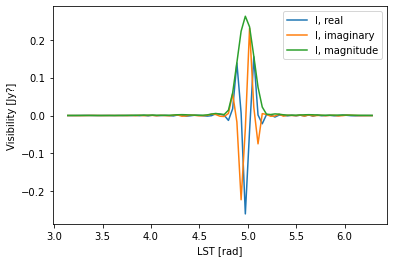

In [19]:
I = np.array([v[1][0] for v in vist])

plt.plot(vist[:, 0], np.real(I), label="I, real")
plt.plot(vist[:, 0], np.imag(I), label="I, imaginary")
plt.plot(vist[:, 0], np.abs(I), label="I, magnitude")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

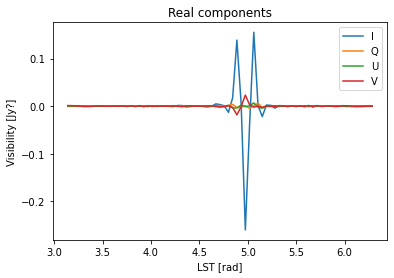

In [20]:
Q = np.array([v[1][1] for v in vist])
U = np.array([v[1][2] for v in vist])
V = np.array([v[1][3] for v in vist])

plt.plot(vist[:, 0], np.real(I), label="I")
plt.plot(vist[:, 0], np.real(Q), label="Q")
plt.plot(vist[:, 0], np.real(U), label="U")
plt.plot(vist[:, 0], np.real(V), label="V")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")
plt.title("Real components")

plt.legend()
plt.show()

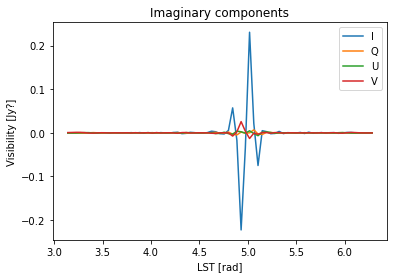

In [21]:
plt.plot(vist[:, 0], np.imag(I), label="I")
plt.plot(vist[:, 0], np.imag(Q), label="Q")
plt.plot(vist[:, 0], np.imag(U), label="U")
plt.plot(vist[:, 0], np.imag(V), label="V")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")
plt.title("Imaginary components")

plt.legend()
plt.show()

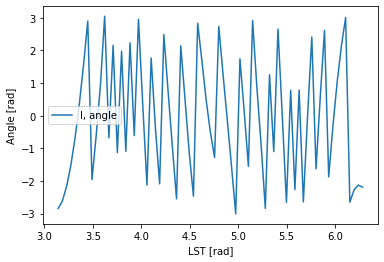

In [23]:
plt.plot(vist[:, 0], np.angle(I), label="I, angle")

plt.xlabel("LST [rad]")
plt.ylabel("Angle [rad]")

plt.legend()
plt.show()

//anaconda3/envs/hera/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


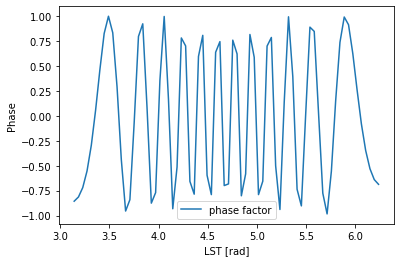

In [30]:
ra = np.radians(arbitrary_source.ra_angle)
dec = np.radians(arbitrary_source.ra_angle)
lst_list = [np.pi / 72 * i for i in range(72, 144)]

phases = np.array([sf.ant.phase_factor(88, 121, sf.rot.radec2lm(ra, dec, ra0=lst)) for lst in 
    lst_list
])
plt.plot(lst_list, phases, label="phase factor")

plt.xlabel("LST [rad]")
plt.ylabel("Phase")

plt.legend()
plt.show()

In [15]:
len(sf.catalog.obj_catalog)

3872